In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [3]:
import os
for dirname, _, filenames in os.walk('/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
path_zip=os.getcwd()+'/input/'

In [5]:
path=os.getcwd()+'/data/'

In [6]:
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [7]:
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

## Data preparation

In [8]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [9]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

## Exploratory data analysis

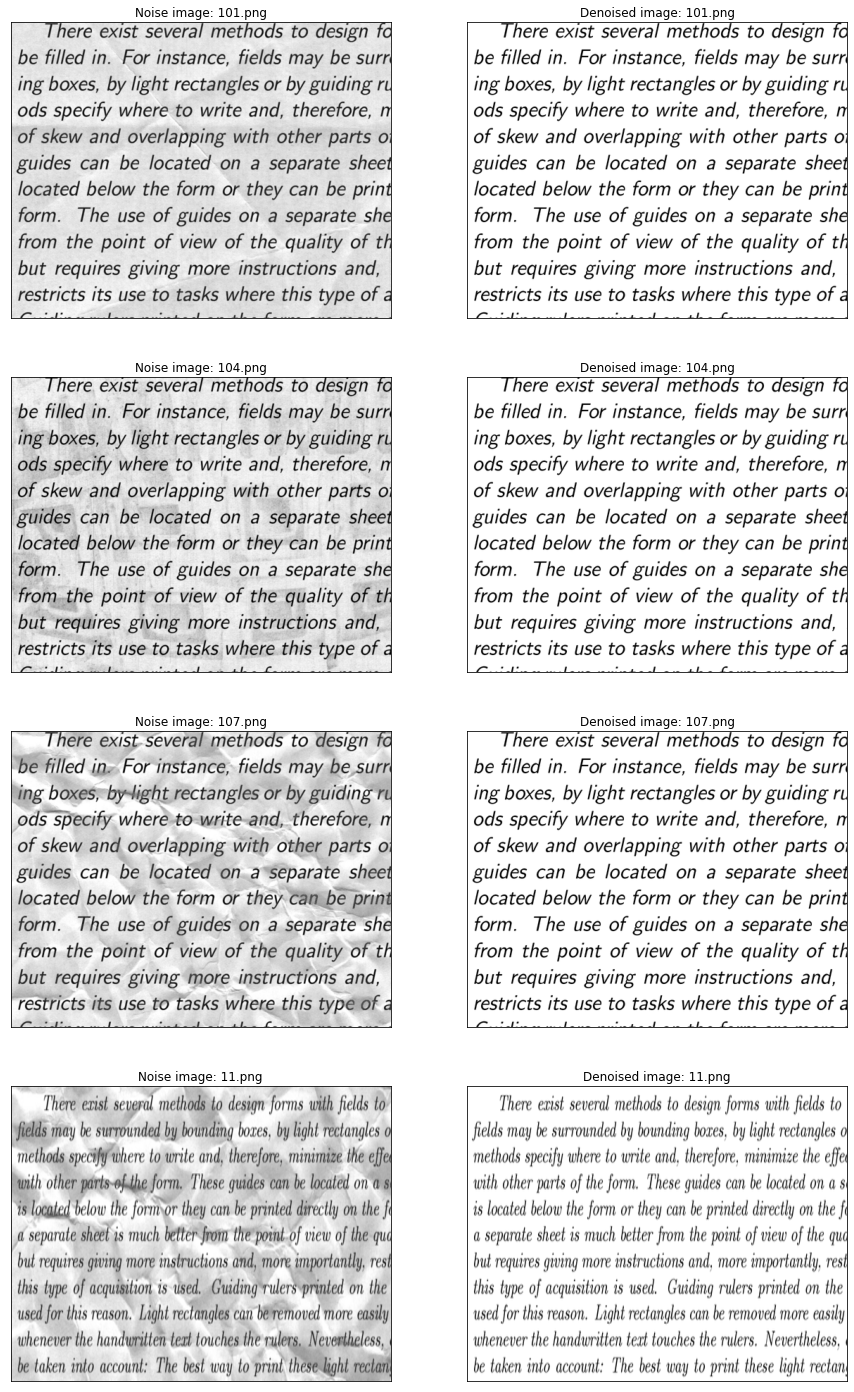

In [10]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

## Split data

In [11]:
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

## Modeling



I have tested many different models and this one brought me to best results (val_loss < 0.0004). Increasing filters, adding another convolutional layer, batch normalization or drop out did not helped to get better score.

Model is pretty simple and it's nice to look at model summary how it works in terms of layer sizes. 420x540 -> 210x270 --> 210x270 -> 420x540

Adam as optimizer is used (as it worked best out of other optimizers), loss is based on mean squared error and we are looking on mean absolute error as well.


In [12]:
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

## Train model

Verbose is going to be set to 0 to avoid filling output with hundreds of lines from training. We will run 300 epochs having early stopping set to 20 (if val loss does not drop in 20 epochs, it will stop).

In [14]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=25, batch_size=24, verbose=1, callbacks=[callback])

Epoch 1/25
6/6 [==============================] - 213s 35s/step - loss: 0.1197 - mae: 0.2419 - val_loss: 0.2228 - val_mae: 0.4583
Epoch 2/25
6/6 [==============================] - 216s 35s/step - loss: 0.0730 - mae: 0.1906 - val_loss: 0.1688 - val_mae: 0.3996
Epoch 3/25
6/6 [==============================] - 214s 35s/step - loss: 0.0513 - mae: 0.1574 - val_loss: 0.1195 - val_mae: 0.3325
Epoch 4/25
6/6 [==============================] - 215s 35s/step - loss: 0.0409 - mae: 0.1445 - val_loss: 0.1061 - val_mae: 0.3102
Epoch 5/25
6/6 [==============================] - 215s 35s/step - loss: 0.0344 - mae: 0.1282 - val_loss: 0.0941 - val_mae: 0.2875
Epoch 6/25
6/6 [==============================] - 214s 35s/step - loss: 0.0298 - mae: 0.1173 - val_loss: 0.0803 - val_mae: 0.2562
Epoch 7/25
6/6 [==============================] - 214s 35s/step - loss: 0.0264 - mae: 0.1099 - val_loss: 0.0706 - val_mae: 0.2232
Epoch 8/25
6/6 [==============================] - 214s 35s/step - loss: 0.0236 - mae: 0.10

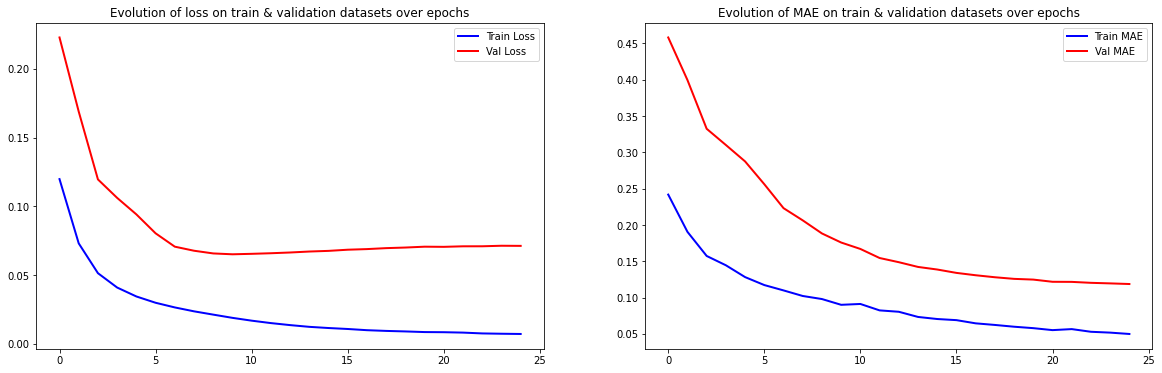

In [15]:


# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()



In [16]:


# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)



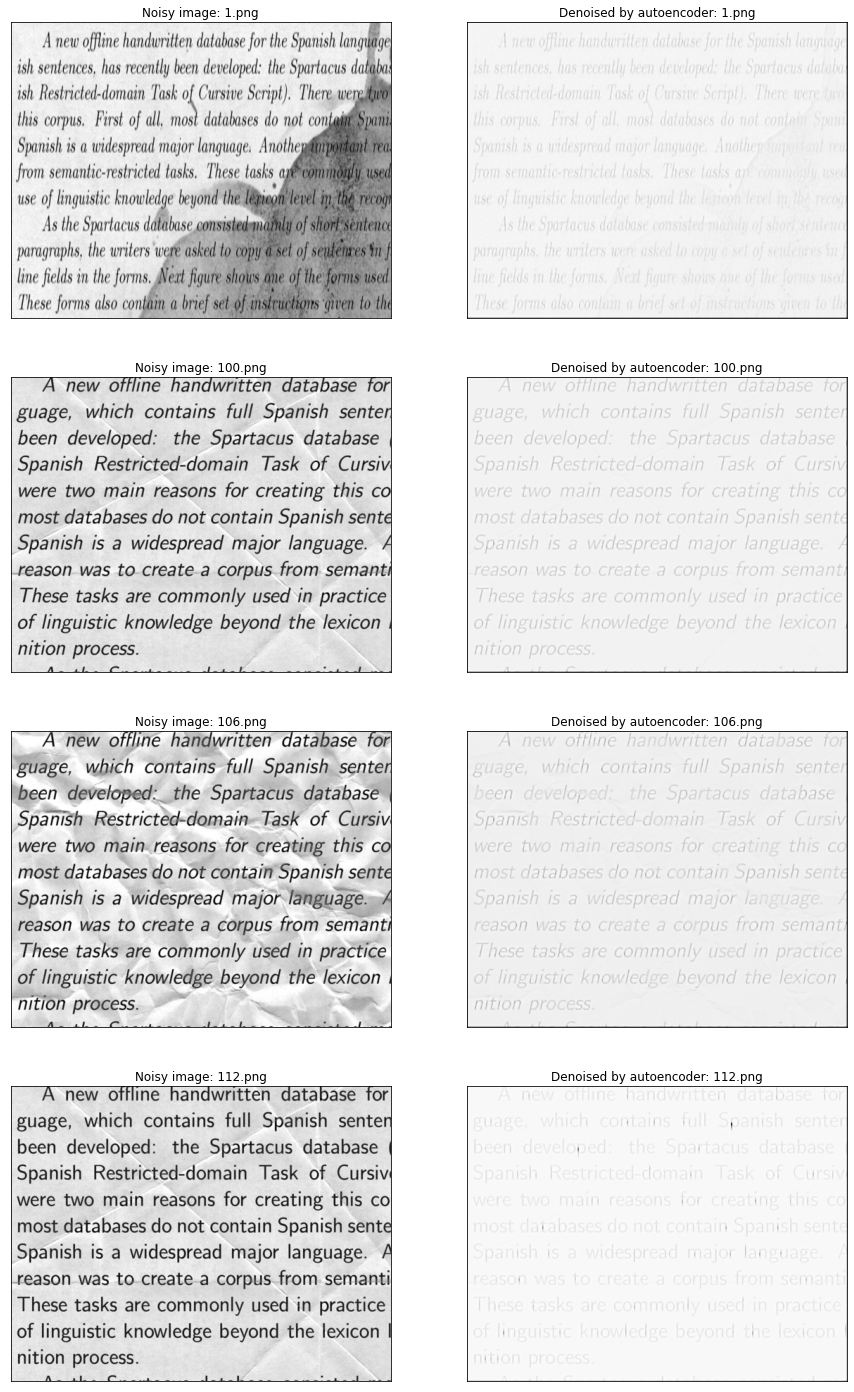

In [17]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()